In [1]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    # !mkdir -p videos
    # !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    # !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [5]:
# !mkdir -p videos/video1/
!mkdir -p videos/video9/

In [ ]:
# !unzip -d videos videos/video1.zip
!unzip -d videos videos/video9.zip

## Loading the SAM2 Video Predictor

In [13]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [14]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

### Select an example video
We assume that the video is stored as a list of JPEG frames with filenames like <frame_index>.jpg.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:

ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
where -q:v generates high-quality JPEG frames and -start_number 0 asks ffmpeg to start the JPEG file from 00000.jpg.

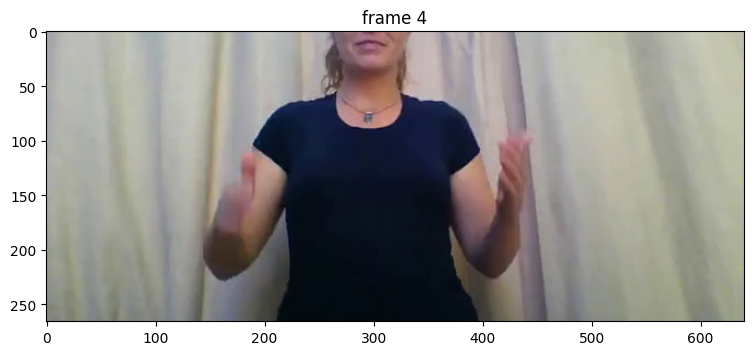

In [19]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/video9"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 4
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

### Initialize the inference state
SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video.

During initialization, it loads all the JPEG frames in video_path and stores their pixels in inference_state (as shown in the progress bar below).

In [51]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 122/122 [00:03<00:00, 37.82it/s]


## Segment multiple objects simultaneously

In [52]:
predictor.reset_state(inference_state)

### Step 1: Add two objects on a frame
SAM 2 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

This time, let's focus on object parts and segment the shirts of both childen in this video. Here we add prompts for these two objects and assign each of them a unique object id.

In [53]:
prompts = {}  # hold all the clicks we add for visualization

Add the first object (the left child's shirt) with a positive click at (x, y) = (200, 300) on frame 0.

We assign it to object id 2 (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the add_new_points_or_box API to distinguish the object we are clicking upon.

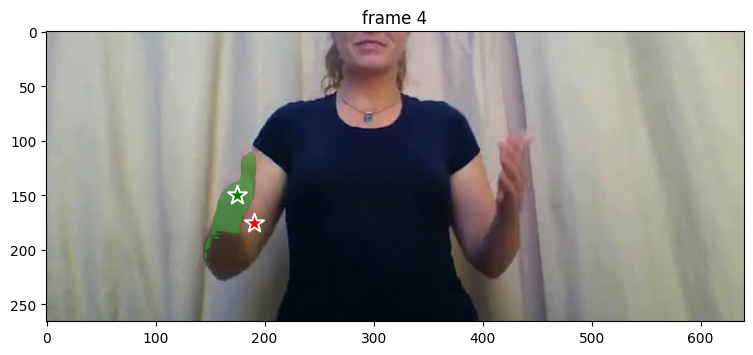

In [55]:
# add the first object
ann_frame_idx = 4  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[175, 150], [190, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

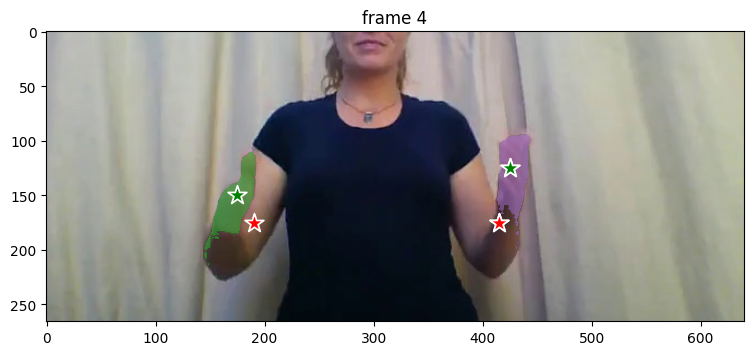

In [59]:
ann_frame_idx = 4  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[425, 125], [415, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

### Step 2: Propagate the prompts to get masklets across the video
Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the propagate_in_video API will return a list of masks for each object.

In [63]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 118/118 [02:44<00:00,  1.39s/it]


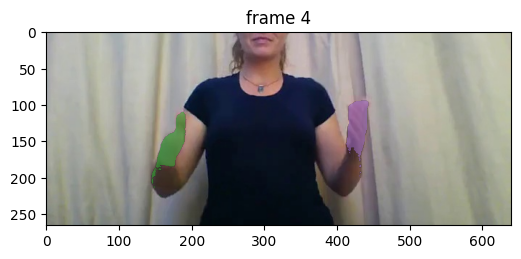

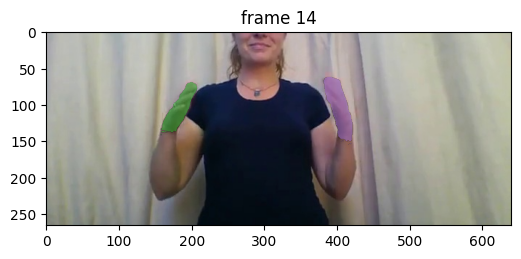

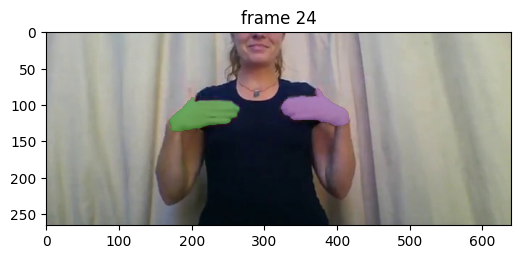

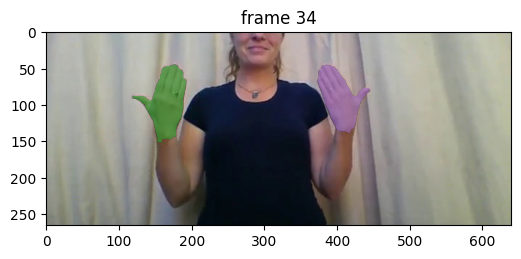

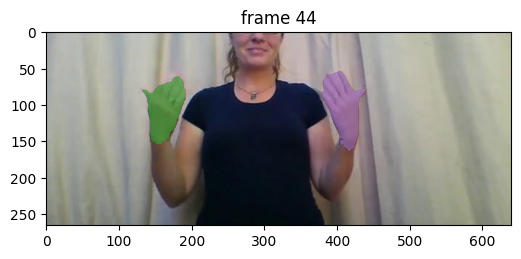

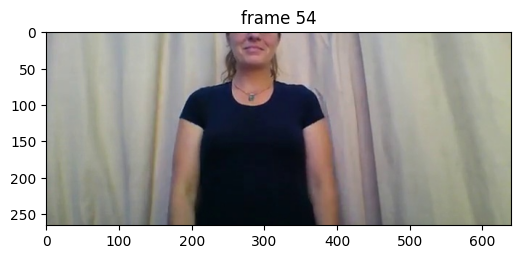

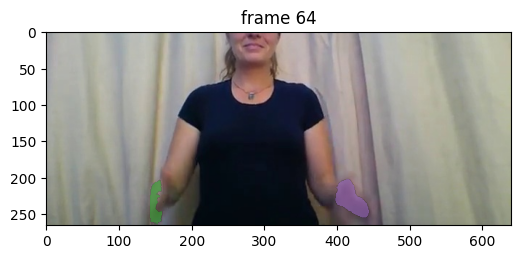

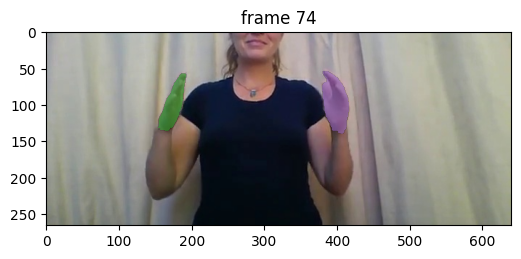

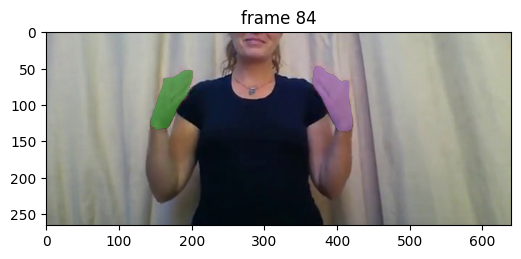

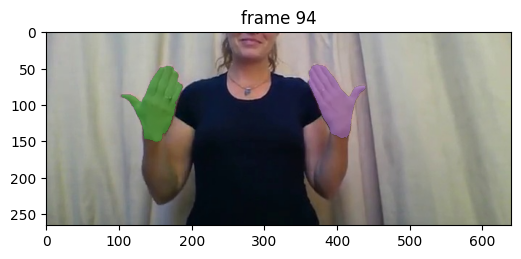

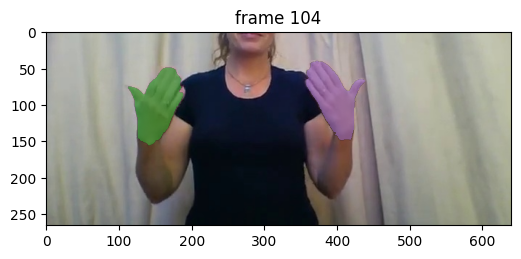

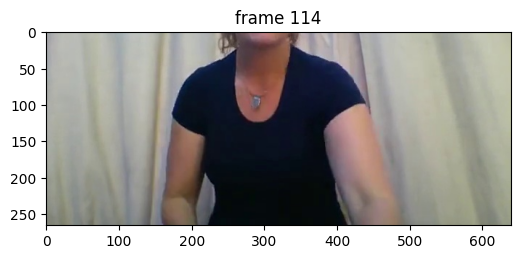

In [64]:
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(4, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)